# Building GPT Model from Scratch
---

In [ ]:
# Import libraries
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn

---
## Preparting Data

---
### Dataset

In [ ]:
# Download the Tiny Shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-04-12 21:54:38--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2025-04-12 21:54:38 (23.4 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
# Read the dataset into a string
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
len(text)

1115394

### Encoding Text

In [ ]:
# Extract unique characters and define vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)

In [ ]:
print("vocab: ", chars)
print("vocab_size:", vocab_size)

vocab:  ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab_size: 65


In [ ]:
# Create mappings
s2i = {ch:i for i,ch in enumerate(chars)}
i2s = {i:ch for i,ch in enumerate(chars)}

In [ ]:
# Encoding and decoding utility functions
encode = lambda s: [s2i[c] for c in s]
decode = lambda l: ''.join([i2s[i] for i in l])

In [ ]:
print(encode("Hello World!"))
print(decode(encode("Hello World!")))

[20, 43, 50, 50, 53, 1, 35, 53, 56, 50, 42, 2]
Hello World!


In [ ]:
encoded_text = encode(text)

In [ ]:
print(encoded_text[:50])

[18, 47, 56, 57, 58, 1, 15, 47, 58, 47, 64, 43, 52, 10, 0, 14, 43, 44, 53, 56, 43, 1, 61, 43, 1, 54, 56, 53, 41, 43, 43, 42, 1, 39, 52, 63, 1, 44, 59, 56, 58, 46, 43, 56, 6, 1, 46, 43, 39, 56]


---
### Prepare Dataset and Data Loader

In [ ]:
# Define sequence length for context window
context_len = 100

In [ ]:
# Create input-output pairs for next-token prediction
source_sequences = [encoded_text[i:i+context_len] for i in range(len(encoded_text) - context_len)]
target_sequences = [encoded_text[i+1:i+1+context_len] for i in range(len(encoded_text) - context_len)]

In [ ]:
# Debug print of first few input-target samples
src, tgt = source_sequences[0], target_sequences[0]

In [ ]:
for t in range(10):
    context = src[:t+1]
    target = tgt[t]
    print(f"when input is {context} or '{decode(context)}' the target: {target} or {decode([target])}")

when input is [18] or 'F' the target: 47 or i
when input is [18, 47] or 'Fi' the target: 56 or r
when input is [18, 47, 56] or 'Fir' the target: 57 or s
when input is [18, 47, 56, 57] or 'Firs' the target: 58 or t
when input is [18, 47, 56, 57, 58] or 'First' the target: 1 or  
when input is [18, 47, 56, 57, 58, 1] or 'First ' the target: 15 or C
when input is [18, 47, 56, 57, 58, 1, 15] or 'First C' the target: 47 or i
when input is [18, 47, 56, 57, 58, 1, 15, 47] or 'First Ci' the target: 58 or t
when input is [18, 47, 56, 57, 58, 1, 15, 47, 58] or 'First Cit' the target: 47 or i
when input is [18, 47, 56, 57, 58, 1, 15, 47, 58, 47] or 'First Citi' the target: 64 or z


In [ ]:
# Convert to PyTorch tensors
source_tensor = torch.tensor(source_sequences)
target_tensor = torch.tensor(target_sequences)

**Exercise 1 [1/1]**:
1. Implement the class `TextDataset`.

In [ ]:
# Dataset class for batching input-output sequences
class TextDataset(torch.utils.data.Dataset):

    def __init__(self, src_seqs, tgt_seqs):
        self.src_seqs = src_seqs
        self.tgt_seqs = tgt_seqs

    def __len__(self):
        return len(self.src_seqs)

    def __getitem__(self, idx):
        return self.src_seqs[idx], self.tgt_seqs[idx]

In [ ]:
# Create dataset and split into training and validation sets
dataset = TextDataset(source_tensor, target_tensor)
n = int(0.9 * len(dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [n, len(dataset) - n])

In [ ]:
# Create DataLoaders for batching
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [ ]:
# Preview one batch
batch = next(iter(train_dataloader))
src, tgt = batch

In [ ]:
print(src.shape)
print(tgt.shape)
print(src)
print(tgt)

torch.Size([64, 100])
torch.Size([64, 100])
tensor([[49, 52, 53,  ..., 53, 59, 57],
        [43, 43,  1,  ..., 41, 43,  7],
        [46, 43,  1,  ...,  1, 51, 63],
        ...,
        [56,  7, 42,  ...,  8,  0,  0],
        [59, 52, 45,  ...,  1, 40, 47],
        [52,  1, 47,  ..., 43,  1, 58]])
tensor([[52, 53, 61,  ..., 59, 57,  0],
        [43,  1, 51,  ..., 43,  7, 40],
        [43,  1, 54,  ..., 51, 63,  1],
        ...,
        [ 7, 42, 43,  ...,  0,  0, 16],
        [52, 45,  1,  ..., 40, 47, 52],
        [ 1, 47, 58,  ...,  1, 58, 46]])


---
## Define the GPT Model

---
### Word Embeddings

In [ ]:
# Define embedding dimension
d_model = 128

In [ ]:
# Create token embedding layer
word_embdedding = nn.Embedding(vocab_size, d_model)

In [ ]:
# Apply word embedding to the source input
src_word_embdedding = word_embdedding(src)

In [ ]:
print(src_word_embdedding.shape)
print(src_word_embdedding[0,:5,:10])

torch.Size([64, 100, 128])
tensor([[ 1.5559,  0.6352, -0.8649, -0.9931,  0.9817,  0.0037,  0.2192,  0.0296,
          0.6097, -0.6155],
        [ 0.3858,  0.4163, -0.0761,  0.7375,  2.2078,  1.1158,  1.0210, -0.8601,
         -0.4254, -0.0618],
        [-1.9824,  1.2528,  0.0600, -1.4221,  0.3807,  0.5240, -1.7595,  0.2200,
          1.5151,  0.8016],
        [-0.1156, -0.1460,  0.6837, -0.9593, -2.2100, -0.3878,  0.0560,  0.1228,
          2.3290, -2.0725],
        [-0.5075,  0.1246,  0.1035,  1.3505,  0.4287,  2.7656, -1.0643, -0.0874,
         -0.9919,  0.5640]], grad_fn=<SliceBackward0>)


---
### Positional Encoding

**Exercise 2 [1/1]**:
1. Implement the `forward()` method in the `PositionalEncoding` class. The `forward` method takes an embedded sequence `x` with shape `(batch_size, context_len, d_model)`, adds the corresponding positional encoding from `pe`, and returns the result.

In [ ]:
# Adds fixed sinusoidal positional encodings to token embeddings to inject sequence order
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, num_range = 5000):

        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.num_range = num_range

        # Create empty encoding matrix
        pe = torch.zeros(num_range, d_model)

        # Position indices
        position = torch.arange(0, num_range).unsqueeze(1)

        # Pre-computed div term for sin/cos calculation
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        # Apply sine to even indices, cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension
        pe = pe.unsqueeze(0)

        # Register as buffer
        self.register_buffer('pe', pe)

    def forward(self, x):

        # Add position encoding to input embeddings
        x = x + self.pe[:, :x.size(1), :]

        return x

In [ ]:
# Initialize positional encoding module
pos_encoding = PositionalEncoding(d_model = d_model, num_range = context_len)

In [ ]:
# Apply positional encoding to embedded input
src_embedded = pos_encoding(src_word_embdedding)

In [ ]:
print(pos_encoding.pe.shape)
print(src_embedded.shape)
print(src_embedded[0,:5,:10])

torch.Size([1, 100, 128])
torch.Size([64, 100, 128])
tensor([[ 1.5559,  1.6352, -0.8649,  0.0069,  0.9817,  1.0037,  0.2192,  1.0296,
          0.6097,  0.3845],
        [ 1.2273,  0.9566,  0.6856,  1.3854,  2.8893,  1.8476,  1.6257, -0.0636,
          0.1078,  0.7842],
        [-1.0731,  0.8366,  1.0470, -1.5825,  1.3781,  0.5949, -0.7963,  0.4886,
          2.4173,  1.2331],
        [ 0.0255, -1.1360,  1.2010, -1.8151, -1.4317, -1.0158,  0.9856, -0.2456,
          3.3223, -2.1884],
        [-1.2643, -0.5291, -0.2132,  0.4020,  0.5703,  1.7756, -0.5467, -0.9430,
         -0.2135, -0.0637]], grad_fn=<SliceBackward0>)


In [ ]:
# Extract the positional encodings matrix as a NumPy array
positional_encodings = pos_encoding.pe[:,:context_len, :d_model].numpy()

In [ ]:
print(positional_encodings.shape)

(1, 100, 128)


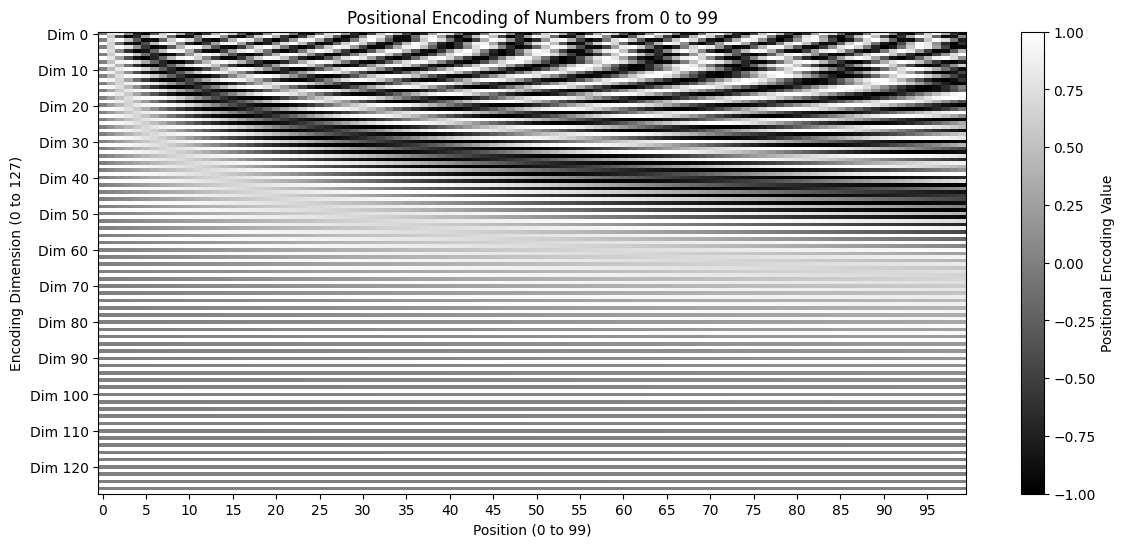

In [ ]:
# Plot positional encoding matrix
plt.figure(figsize = (14, 6))
plt.imshow(positional_encodings.T, aspect = 'auto', cmap = 'gray', interpolation = 'nearest')
plt.colorbar(label = 'Positional Encoding Value')
plt.xlabel(f'Position (0 to {context_len - 1})')
plt.ylabel(f'Encoding Dimension (0 to {d_model - 1})')
plt.title(f'Positional Encoding of Numbers from 0 to {context_len - 1}')
plt.xticks(np.arange(0, pos_encoding.num_range, step = 5))
plt.yticks(np.arange(0, d_model, step = 10), labels = [f'Dim {i}' for i in range(0, d_model, 10)])
plt.show()

In [ ]:
# Create binary representations of 0–99 using d_model-bit width
bit_length = d_model
binary_representation = [np.binary_repr(i, width = bit_length) for i in range(context_len)]

In [ ]:
# Convert to 2D matrix then transpose
binary_matrix = np.array([[int(bit) for bit in bin_str[::-1]] for bin_str in binary_representation])
binary_matrix = binary_matrix.T

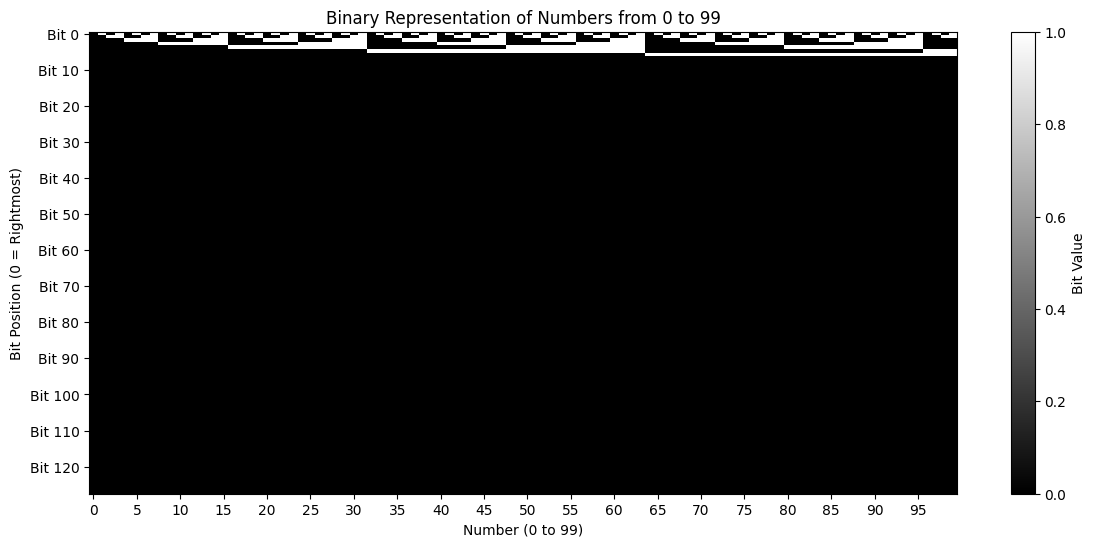

In [ ]:
# Plot binary encoding matrix
plt.figure(figsize = (14, 6))
plt.imshow(binary_matrix, aspect = 'auto', cmap = 'gray', interpolation = 'nearest')
plt.colorbar(label = 'Bit Value')
plt.xlabel('Number (0 to 99)')
plt.ylabel('Bit Position (0 = Rightmost)')
plt.title('Binary Representation of Numbers from 0 to 99')
plt.xticks(np.arange(0, context_len, step = 5))
plt.yticks(np.arange(0, bit_length, step = 10), labels = [f'Bit {i}' for i in range(0, bit_length, 10)])
plt.show()

---
### Single-Head Self-Attention

**Exercise 3 [2/2]**:
1. Implement the class `Head`.

In [ ]:
# Implements a single self-attention head with causal masking for autoregressive decoding
class Head(nn.Module):

    def __init__(self, d_model, d_k, d_v, context_len = 100):

        super().__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.context_len = context_len

        # Linear projections for query, key, and value
        self.W_Q = nn.Linear(d_model, d_k)
        self.W_K = nn.Linear(d_model, d_k)
        self.W_V = nn.Linear(d_model, d_v)

        # Register lower-triangular mask for causal attention
        self.register_buffer("mask", torch.tril(torch.ones(self.context_len, self.context_len)))

    def forward(self, x):

        # Project input into Q, K, V
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        # Compute scaled dot-product attention scores
        scores = Q @ K.transpose(-2, -1) / math.sqrt(self.d_k)

        # Apply causal mask to prevent attending to future tokens
        scores = scores.masked_fill(self.mask[:x.size(1), :x.size(1)] == 0, float('-inf'))

        # Normalize scores to probabilities
        weights = F.softmax(scores, dim = -1)

        # Compute attention output as weighted sum of values
        output = weights @ V

        return output

In [ ]:
# Initialize single-head attention for testing
num_heads = 8
d_k = d_v = d_model // num_heads
head = Head(d_model = d_model, d_k = d_k, d_v = d_v, context_len = context_len)

In [ ]:
# Generate random input
x = torch.randn(batch_size, context_len, d_model)
output = head(x)

In [ ]:
print("Output shape:", output.shape)
print("Output (first example, first few tokens):", output[0, :5, :])

Output shape: torch.Size([64, 100, 16])
Output (first example, first few tokens): tensor([[ 4.9336e-01,  1.7095e-01,  1.7265e-02, -7.7426e-01, -3.8906e-02,
         -4.8482e-01,  6.0729e-01,  5.6286e-01, -6.9106e-01, -2.8601e-01,
          6.9051e-02, -1.0429e-01,  3.5803e-01, -4.0813e-03,  4.8076e-01,
         -1.0538e-01],
        [ 4.8214e-01,  1.4000e-01,  3.0911e-01, -3.8238e-01, -3.2625e-02,
         -2.1414e-01, -1.4858e-02,  6.8674e-01, -6.7315e-01, -2.2306e-01,
          1.9708e-01, -9.2337e-02,  3.5686e-04, -1.6016e-01,  6.4234e-01,
         -1.7230e-01],
        [ 5.4417e-01,  4.1940e-03, -4.9905e-02,  3.1391e-02,  3.5056e-01,
         -5.6806e-01, -6.5135e-01,  1.7725e-01, -1.4457e-01, -4.0365e-01,
          1.8969e-03,  1.0647e-01,  1.2192e-01,  8.7321e-02,  3.3980e-01,
         -2.0373e-01],
        [ 3.7729e-01,  3.6854e-01,  1.4001e-01,  3.8801e-01,  9.1492e-02,
         -3.2939e-01, -6.3382e-01,  5.6626e-02, -2.6929e-01, -5.5201e-01,
         -6.0587e-03,  1.0274e-01, 

---
### Multi-Head Attention

**Exercise 4 [1/1]**:
1. Implement the class `MultiHeadAttention`.

In [ ]:
# Runs multiple parallel self-attention heads and merges their outputs with a final linear projection
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads = 8, context_len = 100):

        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.d_v = d_model // num_heads

        # Create list of attention heads
        self.heads = nn.ModuleList([
            Head(d_model, self.d_k, self.d_v, context_len)
            for _ in range(num_heads)])

        # Final linear projection to merge head outputs
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):

        # Run each head independently
        head_outputs = [head(x) for head in self.heads]

        # Concatenate outputs from all heads
        concat = torch.cat(head_outputs, dim = -1)

        # Project concatenated output back to d_model dimensions
        output = self.linear(concat)

        return output

In [ ]:
# Test multi-head attention module
multi_head_attn = MultiHeadAttention(d_model = d_model, num_heads = num_heads, context_len = context_len)
output = multi_head_attn(src_embedded)

In [ ]:
print("Output shape:", output.shape)
print("Output (first example, first few tokens):", output[0, :5, :10])

Output shape: torch.Size([64, 100, 128])
Output (first example, first few tokens): tensor([[-0.3100, -0.3387,  0.9924, -0.4870, -0.1335,  0.0823, -0.5538, -0.5616,
         -0.2711,  0.0374],
        [-0.3985,  0.1608,  0.8176, -0.2885,  0.0691,  0.1938, -0.0152, -0.4530,
         -0.4788, -0.2139],
        [-0.2790,  0.0730,  0.6717, -0.3254,  0.0424,  0.1304,  0.0049, -0.4234,
         -0.3732, -0.3528],
        [-0.0513,  0.2098,  0.5669, -0.2886,  0.0251,  0.1200,  0.0313, -0.4937,
         -0.1469, -0.1448],
        [-0.0994,  0.0344,  0.4475, -0.2797, -0.0219,  0.1375,  0.0736, -0.4585,
         -0.1503, -0.1643]], grad_fn=<SliceBackward0>)


---
### Feed-Forward Network

**Exercise 5 [1/1]**:
1. Implement the class `FFN`.

In [ ]:
# Applies a two-layer feed-forward network with GELU activation to each token independently
class FeedForward(nn.Module):

    def __init__(self, d_model, d_ff = 256):

        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        # FFN: Linear → GELU → Linear
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model))

    def forward(self, x):
        return self.ffn(x)

In [ ]:
# Instantiate and test FFN
d_ff = 256
ffn = FeedForward(d_model=d_model, d_ff=d_ff)
output = ffn(output)

In [ ]:
print("Output shape:", output.shape)
print("Output (first example, first few tokens):", output[0, :5, :10])

Output shape: torch.Size([64, 100, 128])
Output (first example, first few tokens): tensor([[-0.0934,  0.0546, -0.0246, -0.1522,  0.0157, -0.0143,  0.1076, -0.0467,
         -0.1532,  0.0252],
        [-0.1186,  0.0077,  0.0571, -0.1448,  0.0379,  0.0155,  0.0637, -0.0079,
         -0.1181,  0.1155],
        [-0.1041, -0.0165,  0.0741, -0.1209,  0.0409, -0.0036,  0.0510, -0.0084,
         -0.1149,  0.0950],
        [-0.0830, -0.0218,  0.0462, -0.1355,  0.0484,  0.0019,  0.0649, -0.0414,
         -0.1187,  0.0885],
        [-0.0631, -0.0010,  0.0434, -0.1288,  0.0122,  0.0115,  0.0472, -0.0511,
         -0.1114,  0.0868]], grad_fn=<SliceBackward0>)


---
### Transformer Decoder Layer

**Exercise 6  [1/1]**:
1. Implement the `TransformerDecoderLayer` class.

In [ ]:
# A single Transformer decoder layer with pre-layer normalization, self-attention, and feed-forward network
class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, num_heads = 8, d_ff = 2048, context_len = 100):

        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.context_len = context_len

        # LayerNorms before attention and FFN
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        # Attention and Feed-Forward submodules
        self.attn = MultiHeadAttention(d_model, num_heads, context_len)
        self.ffn = FeedForward(d_model, d_ff)

    def forward(self, x):

        # Residual connection + attention
        x = x + self.attn(self.norm1(x))

        # Residual connection + FFN
        x = x + self.ffn(self.norm2(x))

        return x

In [ ]:
# Instantiate and test single decoder layer
transformer_decoder_layer = TransformerDecoderLayer(d_model = d_model, num_heads = num_heads, d_ff = d_ff, context_len = context_len)
output = transformer_decoder_layer(src_embedded)

In [ ]:
print("Output shape:", output.shape)
print("Output (first example, first few tokens):", output[0, :5, :10])

Output shape: torch.Size([64, 100, 128])
Output (first example, first few tokens): tensor([[ 1.2914,  1.6921, -1.1181, -0.4426,  0.5439,  0.9333,  0.2763,  1.3038,
          0.2183,  0.5726],
        [ 1.1355,  0.7464,  0.4572,  1.2833,  2.8967,  1.9012,  1.6676,  0.3240,
         -0.2773,  1.0735],
        [-0.9900,  1.0145,  0.9630, -1.7443,  1.0828,  0.6171, -0.5437,  0.6859,
          2.2500,  1.1754],
        [ 0.1390, -1.2646,  1.3125, -2.2214, -1.6773, -0.8631,  0.8351, -0.2646,
          3.0608, -1.8451],
        [-0.9347, -0.6392, -0.1912,  0.1251,  0.3856,  2.1120, -0.6278, -0.6080,
         -0.1349,  0.0680]], grad_fn=<SliceBackward0>)


### Stack Decoder Layers

**Exercise 7 [1/1]**:
1. Implement the class `TransformerDecoder`.

In [ ]:
# Stacks multiple Transformer decoder layers to progressively refine token representations
class TransformerDecoder(nn.Module):

    def __init__(self, d_model, num_heads = 8, d_ff = 2048, context_len = 100, num_layers = 6):

        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.context_len = context_len
        self.num_layers = num_layers

        # Stack of decoder layers
        self.layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, num_heads, d_ff, context_len)
            for _ in range(num_layers)])

    def forward(self, x):

        # Pass input sequentially through each layer
        for layer in self.layers:
            x = layer(x)

        return x

In [ ]:
# Instantiate and test multi-layer decoder
num_layers = 2
transformer_decoder = TransformerDecoder(d_model = d_model, num_heads = num_heads, d_ff = d_ff, context_len = context_len, num_layers = num_layers)
output = transformer_decoder(src_embedded)

In [ ]:
print("Output shape:", output.shape)
print("Output (first example, first few tokens):", output[0, :5, :10])

Output shape: torch.Size([64, 100, 128])
Output (first example, first few tokens): tensor([[ 2.7889e+00,  1.5901e+00, -5.5144e-01,  1.1716e+00,  1.4326e+00,
          3.8699e-01,  6.0057e-01,  1.5266e+00,  1.0277e+00, -5.7052e-02],
        [ 1.2868e+00,  1.0874e+00,  7.2921e-01,  2.1291e+00,  3.6082e+00,
          2.0119e+00,  1.7749e+00, -6.6499e-02,  7.9033e-01,  8.7253e-01],
        [-8.1686e-01,  3.6888e-01,  1.4970e+00, -1.0845e+00,  2.6533e+00,
          7.1010e-01,  5.4240e-02,  1.0012e+00,  3.3065e+00,  1.3646e+00],
        [-4.7732e-01, -1.6316e+00,  1.4101e+00, -1.2004e+00, -1.0697e+00,
         -7.0572e-01,  1.3888e+00, -3.6770e-01,  3.6499e+00, -1.8635e+00],
        [-9.9707e-01, -9.8286e-01, -9.8927e-04,  1.0128e+00,  1.1456e+00,
          1.9476e+00, -5.8851e-01, -6.1820e-01,  1.5755e-01,  9.9907e-02]],
       grad_fn=<SliceBackward0>)


---
### Complete GPT Model

**Exercise 8 [2/2]**:
1. Implement `GPTModel`

In [ ]:
# A complete decoder-only GPT model with token/position embeddings, stacked transformer blocks, and text generation
class GPTModel(nn.Module):

    def __init__(self, vocab_size, d_model, num_heads = 8, d_ff = 2048, context_len = 100, num_layers = 6):

        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_ff = d_ff
        self.context_len = context_len
        self.num_layers = num_layers

        # Embedding layers for tokens and positions
        self.word_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, num_range = context_len)

        # Stacked Transformer decoder layers
        self.decoder = TransformerDecoder(d_model, num_heads, d_ff, context_len, num_layers)

        # Final projection to vocabulary size
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):

        # Embed input tokens and add positional encoding
        x = self.word_embedding(x)
        x = self.pos_encoding(x)

        # Pass through stacked decoder layers
        x = self.decoder(x)

        # Project to vocabulary logits
        logits = self.fc_out(x)

        return logits

    @torch.no_grad()

    def generate(self, start_tokens, max_new_tokens = 50, temperature = 1.0):

        # Set model to eval mode
        self.eval()

        # Initial prompt
        generated = start_tokens

        for _ in range(max_new_tokens):

            # Use last context_len tokens as input
            input_seq = generated[:, -self.context_len:]

            # Get logits from model and scale by temperature
            logits = self.forward(input_seq)
            logits = logits[:, -1, :] / temperature

            # Convert to probabilities
            probs = F.softmax(logits, dim = -1)

            # Sample next token
            next_token = torch.multinomial(probs, num_samples = 1)

            # Append token to sequence
            generated = torch.cat((generated, next_token), dim = 1)

        return generated

In [ ]:
# Instantiate and test GPT model
gpt = GPTModel(vocab_size, d_model = d_model, num_heads = num_heads, d_ff = d_ff, context_len = context_len, num_layers = num_layers)
output = gpt(src)

In [ ]:
print("Output shape:", output.shape)
print("Output (first example, first few tokens):", output[0, :5, :10])

Output shape: torch.Size([64, 100, 65])
Output (first example, first few tokens): tensor([[ 0.0096, -0.8940,  1.3199,  1.2045,  0.6285,  0.6677, -0.0681,  1.3730,
          0.0567, -1.1061],
        [-0.3075, -0.1721, -0.1093,  0.1976,  0.3522,  1.2663,  0.5894,  0.6183,
          1.2366, -1.4624],
        [ 0.5688,  0.3384,  0.5509,  0.8342,  1.1753, -0.3357, -0.0758,  0.1398,
          0.4317,  0.4918],
        [ 0.5464, -0.8471,  0.1925,  1.5310,  1.4570,  0.1757, -0.4921,  0.3526,
         -0.3124, -0.4544],
        [ 0.5695, -0.0612,  0.5205,  0.7590,  0.6435,  0.7797,  0.8548,  0.2727,
          0.2954, -0.3125]], grad_fn=<SliceBackward0>)


---
## Training

In [ ]:
def train(model, dataloader, criterion, optimizer, device):

    # Set model to training mode
    model.train()

    total_loss = 0

    for src, tgt in dataloader:

        # Move data to target device
        src, tgt = src.to(device), tgt.to(device)

        # Forward and backward pass
        optimizer.zero_grad()
        output = model(src)
        loss = criterion(output.view(-1, output.size(-1)), tgt.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
def evaluate(model, dataloader, criterion, device):

    # Set model to evaluation mode
    model.eval()

    total_loss = 0

    # Disable gradient calculation
    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src)
            loss = criterion(output.view(-1, output.size(-1)), tgt.view(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(1)

In [ ]:
# Use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


In [ ]:
# Define model architecture hyperparameters
d_model = 128
num_heads = 8
d_ff = 256
num_layers = 2

In [ ]:
print(f"data hyper-paras: vocab_size: {vocab_size}, context_len: {context_len}, batch_size: {batch_size}")
print(f"model hyper-paras: d_model: {d_model}, num_heads: {num_heads}, d_ff: {d_ff}, num_layers: {num_layers}")

data hyper-paras: vocab_size: 65, context_len: 100, batch_size: 64
model hyper-paras: d_model: 128, num_heads: 8, d_ff: 256, num_layers: 2


In [ ]:
# Initialize GPT model, loss function, and optimizer
gpt = GPTModel(vocab_size, d_model = d_model, num_heads = num_heads, d_ff = d_ff, context_len = context_len, num_layers = num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gpt.parameters(), lr = 0.01)

In [ ]:
train_losses = []
val_losses = []
max_iter = 10

# Train the model for a fixed number of epochs
for epoch in range(max_iter):

    train_loss = train(gpt, train_dataloader, criterion, optimizer, device)
    val_loss = evaluate(gpt, val_dataloader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{max_iter}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/10, Train Loss: 1.3860, Val Loss: 1.3115
Epoch 2/10, Train Loss: 1.2893, Val Loss: 1.2795
Epoch 3/10, Train Loss: 1.2694, Val Loss: 1.2649
Epoch 4/10, Train Loss: 1.2584, Val Loss: 1.2565
Epoch 5/10, Train Loss: 1.2513, Val Loss: 1.2459
Epoch 6/10, Train Loss: 1.2461, Val Loss: 1.2452
Epoch 7/10, Train Loss: 1.2419, Val Loss: 1.2367
Epoch 8/10, Train Loss: 1.2386, Val Loss: 1.2385
Epoch 9/10, Train Loss: 1.2357, Val Loss: 1.2404
Epoch 10/10, Train Loss: 1.2334, Val Loss: 1.2257


## Generation

In [ ]:
# Generate new text and decode it to string
context = torch.zeros((1, 1), dtype = torch.long, device = device)

In [ ]:
print(decode(gpt.generate(context, max_new_tokens = 2000)[0].tolist()))


And meacoch Talicise a king; why, there is King Northumberland,
She more take of Lord Hastings and fined by oath,
To this, youth much have tuned jest,
And seek times house it storess,
The pleasant her navy justican.

DUKE VINCENTIO:
I am stuff'd it: stand, gentle loves for breathes;
Or if dotted near that to our quarrel,
But not to make the woman's tire at mind
Without my grieving in the sweeting, shall be Edward
Good Captain.--Nurbeous,--

Roman:
It were proud hearts! Did I not hear me,
That the Thursday, bitterly good
Tickly queen as in the stones of them and heirs,
Amain's instrument, such a man of treason;
And take beguiles to be groweved i' the day?
O Cenelt, Warwick! make each fair slave, beseech you
Have betain me from the man's brains
Of ords, bake my flesh and caldens themselves? whither?
Here in false and lunatice moest windix,
Carristerns to codit when he said to forget
At English frown of Edward's man;
This precise her love the wont with him.
What is your came to accident 